In [1]:
## VISSIM Modules
import win32com.client as com
import os

## RL Modules
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("ERROR: GPU DEVICE NOT FOUND.")

from keras.models import load_model
    
## Data Management Modules
import pickle

## User Defined Modules
import Simulator_Functions as SF
from RLAgents import DQNAgent
from NParser import NetworkParser
from COMServer import COMServerDispatch, COMServerReload, Select_Vissim_Mode
from TupleToList import toList
from Utilities import log_progress, pltlive
from SurtracAgent import SurtracAgent
## Other Modules
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Default GPU Device: /device:GPU:0


Using TensorFlow backend.


In [2]:
## RL Hyperparamenters
# Number of simulations, save every "n" episodes and copy weights with frequency "f"
episodes = 400
partial_save_at = 100
copy_weights_frequency = 5

# Timesteps per simulation (1 timestep = 0.1 sec), length for random population is a multiple of episode
timesteps_per_second = 1
seconds_per_green = 6
seconds_per_yellow = 3
simulation_length = 3600*1 + 1
memory_population_length = (simulation_length-1)*1+1

## State-Action Parameters
action_type = "phases"        # options are "phases" and "programs"
state_size = 4
action_size = 2

# Hyperparameters
PER_activated = False


# Demand Schedule (times in seconds, demand in cars/hour as PPP)
demand_change_timesteps = 450
demand = {"h":800, 'm':400, 'l':200}
demand_list = [[demand['l'], demand['l']], [demand['m'], demand['l']],\
              [demand['h'], demand['l']], [demand['h'], demand['m']],\
              [demand['h'], demand['h']], [demand['m'], demand['h']],
              [demand['l'], demand['h']], [demand['l'], demand['m']]]

In [3]:
## Operation mode (selects functionalities)
mode = "test"
# "populate" = population of memory, generation of initial memory file
# "training" = training agents, maximum speed, frozen UI, mid amount of messages
# "debug"    = trains for 1 episode, minimum speed, working UI, all messages
# "demo"     = loads pretrained agent, minimum speed, working UI
# "test"     = executes evaluation, maximum speed

if mode == 'demo' :
    simulation_length = 3600
    demand_list = [[demand['l'], demand['l']], [demand['l'], demand['l']]]
    demand_change_timesteps = simulation_length
    
    
if mode == 'test' : 
    simulation_length = 3600
    demand_change_timesteps = 450
    demand = {"h":800, 'm':400, 'l':200}
    demand_list = [[demand['l'], demand['l']], [demand['m'], demand['l']],\
                  [demand['h'], demand['l']], [demand['h'], demand['m']],\
                  [demand['h'], demand['h']], [demand['m'], demand['h']],
                  [demand['l'], demand['h']], [demand['l'], demand['m']]]

model_name  = 'Single_Cross_Straight'
vissim_working_directory = 'C:\\Users\\Rzhang\\Desktop\\MLforFlowOptimisation\\Vissim\\'
agent_type = "Surtrac"
Surtrac = True
#agent_type = 'DQN' # DQN, DuelingDQN, DDQN, DuelingDDQN Surtrac
reward_type = 'Queues'  
state_type  = "Clusters"
#state_type  = 'Queues'    # 'Queues', 'Delays', 'QueueDifference' Clusters 
Random_Seed = 42

## Use of additional files?
flag_read_additionally  = False
SaveResultsAgent = False
# Random demand
Random_Demand = False

# Session ID
#Session_ID = 'Ep_'+str(episodes)+'_A_'+agent_type+"_Act_"+action_type+"_Rew_"+reward_type

# Adding the state type to the Session_ID
Session_ID = 'Ep_'+str(episodes)+'_A_'+agent_type+"_State_"+state_type+"_Act_"+action_type+"_Rew_"+reward_type
print(Session_ID)


Ep_400_A_Surtrac_State_Clusters_Act_phases_Rew_Queues


In [ ]:
if __name__ == "__main__":
    # Initialize storage
    reward_storage = []
    best_agent_weights = []
    best_agent_memory = []
    reward_plot = np.zeros([episodes,])
    loss_plot = np.zeros([episodes,])

    # Initialize simulation
    Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                                memory_population_length, timesteps_per_second,\
                                                                delete_results = True, verbose = True)
    Select_Vissim_Mode(Vissim,mode)
        
    # Setting Random Seed
    Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
    print ('Random seed set in simulator. Random Seed = '+str(Random_Seed))

    # Deploy Network Parser (crawl network)
    npa = NetworkParser(Vissim)
    print('NetworkParser has succesfully crawled the model network.')
    
    # Initialize agents
    if agent_type == "Surtrac":
        Agents = [SurtracAgent(state_size, action_size, ID, state_type, npa,\
                  Vissim, delta =2 , rounding=0.1 ) for ID in npa.signal_controllers_ids]
        agents_deployed = True
    else:
        print("Incorrect Agent Class selected. Deployment could not be completed.")
        quit()
    if agents_deployed:
        print("Deployed {} agent(s) of the Class {}.".format(len(Agents), agent_type))
    
    
    ## EXECUTION OF A DEMONSTRATION RUN (slow, choice of best available agent)
    
    if mode == "demo" or mode == "populate" or mode == "debug" or mode == "test":

        # If mode or debug, set slow simulation
        if mode == "demo" or mode =="debug":
            timesteps_per_second = 10
            Vissim.Simulation.SetAttValue('SimRes', timesteps_per_second)
            
        # If memory population or test mode, set quick simulation
        elif mode == "populate" or mode == "test":
            SF.Set_Quickmode(Vissim, timesteps_per_second)
            
            
    # Run the episode
        if mode == "demo" or mode == "debug":
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, memory_population_length,\
                                      timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                                      demand_list, demand_change_timesteps, mode, PER_activated, Surtrac =True)
        elif mode == "test":
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length,\
                                      timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                                      demand_list, demand_change_timesteps, mode, PER_activated, Surtrac =True)
        
        
        Vissim = None
        
        
   

Working Directory set to: C:\Users\Rzhang\Desktop\MLforFlowOptimisation\Vissim\
Generating Cache...


In [11]:
# Plotting training progress
plt.figure(figsize=(8,4.5))
x_series = range(1,len(reward_storage)+1)
fit = np.polyfit(x_series,reward_storage,1)
fit_fn = np.poly1d(fit) 
plt.plot(x_series,reward_storage, '-b', x_series, fit_fn(x_series), '--r')
plt.xlabel('Episodes')
plt.ylabel('Average agent reward in episode')
plt.title('Training evolution and trend')
plt.gca().legend(('Episode Reward','Linear Trend'))
plt.show()

# Plotting training loss
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].loss)+1)
plt.plot(x_series,Agents[0].loss, '-b')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.gca().legend(('Loss'))
plt.show()

TypeError: expected non-empty vector for x

<Figure size 576x324 with 0 Axes>

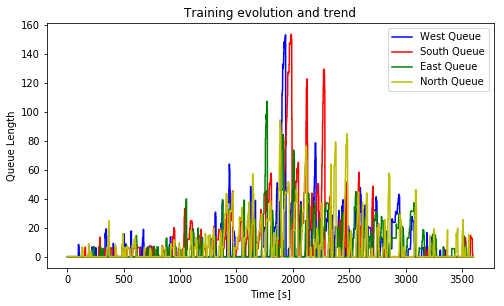

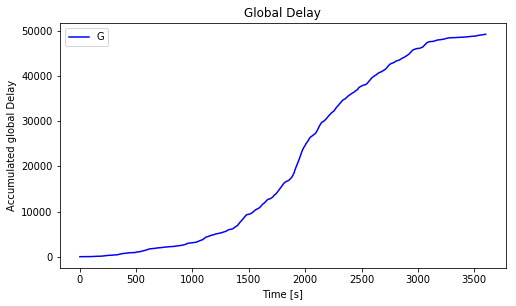

Average queue size is 8.29


In [12]:
# Plotting test progress:
West_queue = list()
South_queue= list()
East_queue = list()
North_queue= list()
# Queue Lengths
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].queues_over_time)+1)
for i in range(len(Agents[0].queues_over_time)):
    West_queue.append(Agents[0].queues_over_time[i][0])
    South_queue.append(Agents[0].queues_over_time[i][1])
    East_queue.append(Agents[0].queues_over_time[i][2])
    North_queue.append(Agents[0].queues_over_time[i][3])
plt.plot(x_series, West_queue, '-b',\
         x_series, South_queue, '-r',\
         x_series, East_queue, '-g',\
         x_series, North_queue, '-y')
plt.xlabel('Time [s]')
plt.ylabel('Queue Length')
plt.title('Training evolution and trend')
plt.gca().legend(('West Queue','South Queue', 'East Queue', 'North Queue'))
plt.show()

# Accumulated delay over time
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].accumulated_delay)+1)
plt.plot(x_series,Agents[0].accumulated_delay, '-b')
plt.xlabel('Time [s]')
plt.ylabel('Accumulated global Delay')
plt.title('Global Delay')
plt.gca().legend('GLlobal accumulated delay')
plt.show()

average_queue_length = np.mean(Agents[0].queues_over_time)
print("Average queue size is {}".format(np.round(average_queue_length,2)))

In [ ]:
int(3.01)